In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import holidays
import matplotlib.pyplot as plt
import math
import re
from typing import Union, Dict, List, Callable
import statsmodels
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
#     import sklearn
import prophet
from prophet import Prophet
import bokeh
from bokeh.models import CustomJS, ColumnDataSource, Slider, Label, Div, HoverTool, Band, Span, BoxAnnotation
from bokeh.plotting import figure
from bokeh.palettes import Spectral11
import ipywidgets as widgets
from IPython.display import display
from typing import Union, Dict, List, Callable
from contextlib import contextmanager
import sys, os
import datetime as dt

In [2]:
# raw data
fact_order = pd.read_pickle('data/fact_order.pkl')
dim_store = pd.read_pickle('data/dim_store.pkl')
df = fact_order.join(dim_store.set_index('store_id'), on='store_id').drop('store_id', axis=1).reset_index()

In [3]:
# investigate the data
for i in dim_store.columns:
    if i in ["store_group","store_format","store_level","store_segment"]:
        print(f"---{i}:\n{dim_store[i].value_counts()} ")

---store_group:
Trực thuộc      43
Nhượng quyền    19
Name: store_group, dtype: int64 
---store_format:
Phố     42
Mall    20
Name: store_format, dtype: int64 
---store_level:
C      22
B      12
A      12
A+      1
A++     1
Name: store_level, dtype: int64 
---store_segment:
Mass          30
Mainstream    15
Flagship       3
Name: store_segment, dtype: int64 


In [4]:
dim_store[dim_store['store_level']=="A++"].head()

,store_id,store_name,store_group,store_format,store_level,store_segment,store_area,number_of_staff,province
23,328165,AEON TÂN PHÚ,Trực thuộc,Mall,A++,Flagship,380.0,14.0,Hồ Chí Minh


In [5]:
def preprocessing(df, store_name = 'AEON TÂN PHÚ', period = "Day"):
    
    dataframe = df.copy()
    # rename columns
    dataframe.columns = ['date', 'sales', 'store', 'store_group', 'store_format', 'store_level', 'store_segment', 'store_area', 'number_of_staff', 'province']

    # set datetime index
    dataframe.date = pd.to_datetime(dataframe.date)
    dataframe.set_index('date', inplace=True)

    # remove wholesale orders (sales >20mil)
    dataframe = dataframe.loc[dataframe.sales < 20000000]

    # trim dates
    date_start = datetime.date(2018, 1, 1)
    # date_start = datetime.date(2017, 9, 1)
    date_end = datetime.date(2021, 3, 31)
    dataframe = dataframe.sort_index().loc[date_start:date_end+datetime.timedelta(days=1)]

    # keep only stores with data from date_start to date_end; remove the rest
    store_groups = dataframe.groupby('store')
    dataframe = store_groups.filter(lambda group: (group.index.min().date() == date_start) & (group.index.max().date() == date_end))
    #df.store.drop_duplicates()#.shape

    # missing values
    data = dataframe[['sales', 'store']].groupby('store').resample('D').sum()
    data.replace(0, np.nan, inplace=True)
    #data.sort_values('sales')
    nan_idx = np.where(data.sales.isna())
    #data.iloc[nan_idx]
    data = (data.groupby('store')).transform(lambda x : x.interpolate()).reset_index('store')
    #data.iloc[nan_idx]

    # add holiday
    holiday = pd.DataFrame(holidays.Vietnam(years=[2018, 2019, 2020, 2021]).items()).rename({0:'date', 1:'holiday_neg'}, axis=1).set_index('date')
    #holiday.index = pd.PeriodIndex(holiday.index, freq='D')
    # set to 1 if holiday affect sales negatively
    holiday.replace({'Vietnamese New Year.*': 1, 
                     '.*day of Tet Holiday': 1,
                     'International Labor Day': 1,
                     '\D': 0}, 
                    regex=True, inplace=True)

    #data.index = data.index.to_period('D')
    data = pd.merge(data, holiday, how='left', left_index=True, right_index=True)
    if period == "Month":
        print("WIP")
    elif period == "Week":
        # resample to weekly frequency
        #data=data[data['store']==store_name]
        data = data[['sales','holiday_neg']].resample('M',kind='timestamp',label ='right').sum()
        return data
    else:
        return data   

        
def plot_series(data,figsize=(12,6)):
    plt.figure(figsize=figsize)
    plt.title('Quantity Timeseries')
    plt.xticks(rotation=45)
    plt.plot(data) 

In [6]:
# final df of aggregated data of all store
final_df = preprocessing(df)
# Choose
final_df = final_df[['sales','store']].reset_index().groupby(['date','store']).sum().reset_index()
final_df['sales'] = round(final_df['sales']/1000)

In [7]:
final_df.head()

,date,store,sales
0,2018-01-01,AEON BÌNH DƯƠNG,62233.0
1,2018-01-01,AEON BÌNH TÂN,67329.0
2,2018-01-01,AEON TÂN PHÚ,116391.0
3,2018-01-01,BIÊN HÒA,13850.0
4,2018-01-01,BUÔN MA THUỘT,9527.0


### Trend and seasonality

In [8]:
def add_datepart(df, fldname, inplace=False, drop=False):
    if not inplace: df = df.copy()        
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','Weekofyear']
#   attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','Weekofyear',
#             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: 
        df.drop(fldname, axis=1, inplace=True)
    if not inplace: 
        return df 

    
store = 'AEON TÂN PHÚ'    
df_trainext = add_datepart(final_df[final_df['store']==store][['sales','date']], 'date', inplace=False)

# df_testext = add_datepart(df_test, 'date', inplace=False)
display(df_trainext.head(3))

<ipython-input-8-a6c9162089a1>:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[targ_pre + n] = getattr(fld.dt, n.lower())


,sales,date,Year,Month,Week,Day,Dayofweek,Dayofyear,Weekofyear
2,116391.0,2018-01-01,2018,1,1,1,0,1,1
27,30026.0,2018-01-02,2018,1,1,2,1,2,1
52,27010.0,2018-01-03,2018,1,1,3,2,3,1


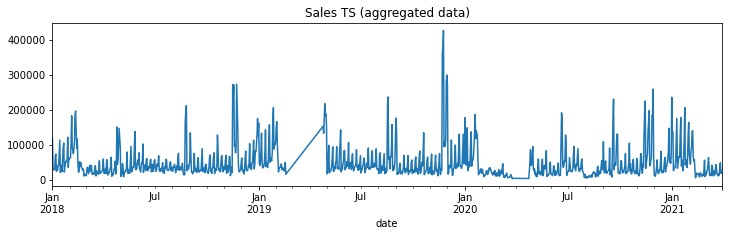

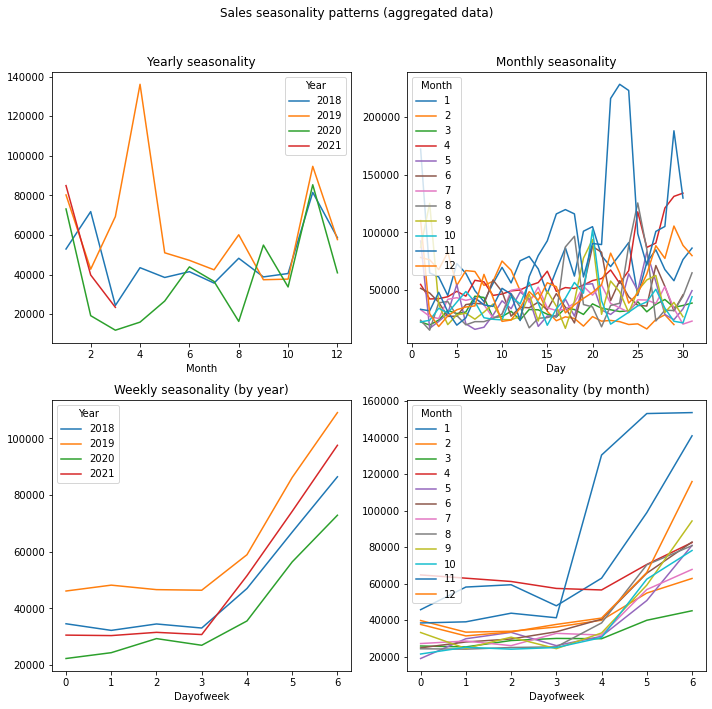

In [9]:
df_trainext.groupby('date').mean()['sales'].plot(figsize=(12,3), title='Sales TS (aggregated data)')

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
_ = pd.pivot_table(df_trainext, values='sales', columns='Year', index='Month').plot(title="Yearly seasonality", ax=ax[0,0])
_ = pd.pivot_table(df_trainext, values='sales', columns='Month', index='Day').plot(title="Monthly seasonality", ax=ax[0,1])
_ = pd.pivot_table(df_trainext, values='sales', columns='Year', index='Dayofweek').plot(title="Weekly seasonality (by year)", ax=ax[1,0])
_ = pd.pivot_table(df_trainext, values='sales', columns='Month', index='Dayofweek').plot(title="Weekly seasonality (by month)", ax=ax[1,1])
fig.suptitle('Sales seasonality patterns (aggregated data)')
fig.tight_layout(rect=[0, 0, 1, 0.96])

Key insights:
- Monthly trend: Sales usually peaked in Tet holidays, Independent day, Backtoschool, and Black Friday
- Weekly trend: Weekend, especially Sunday has the best sales

Evaluation metric: SMAPE

In [10]:
def smape(y: Union[np.ndarray, float], yhat: Union[np.ndarray, float], average=True, signed=False) -> float:
    """SMAPE evaluation metric"""
    
    if signed:
        result = 2. * (yhat - y) / (np.abs(y) + np.abs(yhat)) * 100
    else:
        result = 2. * np.abs(yhat - y) / (np.abs(y) + np.abs(yhat)) * 100
    if average: return np.mean(result)
    return result

def smape_df(df: pd.DataFrame, average=True, signed=False) -> pd.DataFrame:
    return smape(df.y, df.yhat, average=average, signed=signed)

Processing data for prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
816,2020-03-27,59100.074443,13684.984745,106834.147177,58420.892842,59584.430802,-1263.113820,-1263.113820,-1263.113820,-2437.733796,-2437.733796,-2437.733796,1174.619976,1174.619976,1174.619976,0.0,0.0,0.0,57836.960623,3455.0
817,2020-03-28,59080.392289,34560.618318,125888.341861,58388.047293,59574.813445,21728.156340,21728.156340,21728.156340,21119.616304,21119.616304,21119.616304,608.540036,608.540036,608.540036,0.0,0.0,0.0,80808.548629,3444.0
818,2020-03-29,59060.710135,52793.259530,148521.428114,58363.204772,59565.123791,42592.630742,42592.630742,42592.630742,42297.552951,42297.552951,42297.552951,295.077791,295.077791,295.077791,0.0,0.0,0.0,101653.340877,3433.0


C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\statsmodels\stats\diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


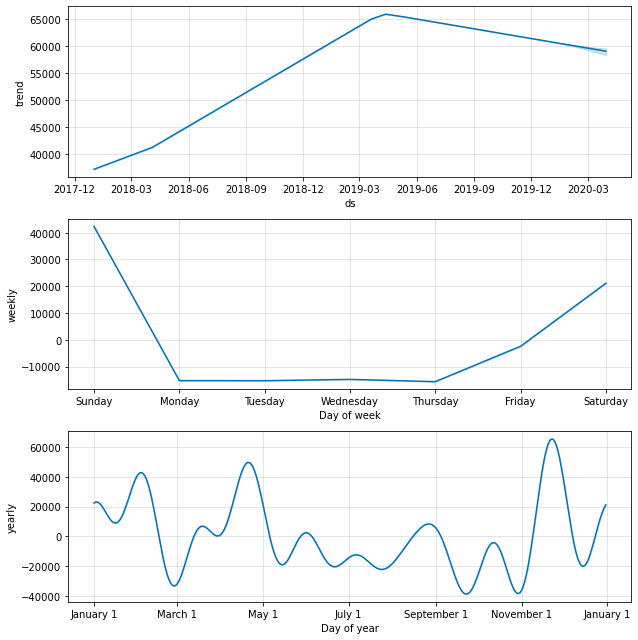

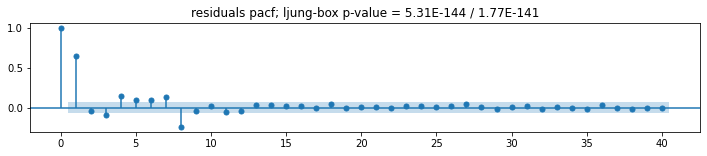

In [12]:
def prophet_show(store, df_train, cutoff_train, cutoff_eval, prophet_kwargs, title, 
                 plot_components=True, display_df=True):
    ts = (df_train.query('store == @store & date < @cutoff_eval')[['date', 'sales']]
          .rename(columns={'date':'ds', 'sales':'y'})).reset_index(drop=True)    #getting time-series dataframe
    ind_train = pd.eval('ts.ds < cutoff_train') #getting training index
    ind_eval = ~ ind_train  #getting eval index
    len_train, len_eval = ind_train.sum(), ind_eval.sum() #len of data
    ts_train = ts.loc[ind_train]  #training ts
    m = Prophet(**prophet_kwargs) #init prophet
    m.fit(ts_train)
    ts_hat = m.predict(ts).merge(ts[['ds', 'y']], on='ds', how='left') #adding prediction
    if display_df: display(ts_hat.tail(3)) #print the finalized df
    # getting scores   
    df_combined = ts_hat.assign(smape=0, smape_smooth=0)
    df_combined.smape = smape_df(df_combined, average=False)
    df_combined.loc[ind_train, 'smape_smooth'] = lowess(df_combined.loc[ind_train, 'smape'], range(len_train), frac=0.03, return_sorted=False)
    df_combined.loc[ind_eval, 'smape_smooth'] = lowess(df_combined.loc[ind_eval, 'smape'], range(len_eval), frac=0.35, return_sorted=False)
    smape_in = df_combined.loc[ind_train].smape.mean()
    smape_oos = df_combined.loc[ind_eval].smape.mean()
    
    source = ColumnDataSource(data=df_combined)
    p = figure(plot_width=750, plot_height=200, title=("**{}**    store = {}     train / test = ..{} / ..{}"
                                                       .format(title, store, cutoff_train, cutoff_eval)), 
               x_axis_type='datetime', tools="pan,wheel_zoom,reset")
    _ = p.line(x='ds', y='yhat', source=source)
    _ = p.line(x='ds', y='yhat_lower', source=source, line_alpha=0.4)
    _ = p.line(x='ds', y='yhat_upper', source=source, line_alpha=0.4)
    _ = p.scatter(x='ds', y='y', source=source, color='black', radius=0.2, radius_dimension='y', alpha=0.4)
    _ = p.scatter(x='ds', y='y', source=source, color='black', radius=0.2, radius_dimension='y', alpha=0.4)
       
    deltas = np.abs(m.params['delta'][0])
    delta_max = np.max(deltas)
    df_deltas = pd.DataFrame({'ds': m.changepoints.values, 'delta':deltas, 'delta_scaled':ts_hat.yhat.mean() * deltas / delta_max})
    source2 = ColumnDataSource(df_deltas)
    cp1 = p.vbar(x='ds', source=source2, width=1, top=ts_hat.yhat.mean(), color='red', alpha=0.2, hover_color='red', hover_alpha=1)
    cp2 = p.vbar(x='ds', source=source2, width=1.5e+9, top='delta_scaled', color='red', alpha=0.5)
    p.add_tools(HoverTool(tooltips=[('trend delta', '@delta{.000}')], renderers=[cp2], mode='mouse'))
    # p.add_layout(Label(x=1e+10, y=10, text='xasfdfsdfsd'))
    p.add_layout(BoxAnnotation(left=ts_train.ds.iloc[-1], right=ts.ds.iloc[-1]))
    
    p2 = figure(plot_width=750, plot_height=100, title="SMAPE IS / OOS = {:.3f} / {:.3f}".format(smape_in, smape_oos), x_axis_type='datetime', tools="",
                x_range=p.x_range)
    sm1 = p2.line(x='ds', y='smape_smooth', source=source, color='green')
    p2.add_tools(HoverTool(tooltips=[('smape', '@smape')], renderers=[sm1], mode='vline', line_policy='interp'))
    p2.add_layout(BoxAnnotation(left=ts_train.ds.iloc[-1], right=ts.ds.iloc[-1]))
    p2.yaxis[0].ticker.desired_num_ticks = 2
    bokeh.io.show(bokeh.layouts.column(p, p2))
    
    if plot_components:
        _ = m.plot_components(ts_hat, uncertainty=True)
        fig, ax = plt.subplots(1, 1, figsize=(12, 2))
#         res = ts_hat.query('ds < @cutoff_train').yhat - ts_train.y
        res = (df_combined['y'] - df_combined['yhat'])
#         adfuller_stat = statsmodels.tsa.stattools.adfuller(res.values)
        ljungbox_stat = statsmodels.stats.diagnostic.acorr_ljungbox(res.values)
        _ = statsmodels.graphics.tsaplots.plot_pacf(res, lags=40, ax=ax,
                                                    title='residuals pacf; ljung-box p-value = {:.2E} / {:.2E}'.format(ljungbox_stat[1][6], 
                                                                                                                      ljungbox_stat[1][30]))
    

prophet_show(store='AEON TÂN PHÚ',df_train = final_df.copy(), cutoff_train="2020-01-01", cutoff_eval="2020-03-30",
             prophet_kwargs={'yearly_seasonality':True, 'weekly_seasonality':True,
                            'uncertainty_samples':500},
            title='Prophet')

In [14]:
# add holiday
holiday = pd.DataFrame(holidays.Vietnam(years=[2018, 2019, 2020, 2021]).items())
holidays_vn = pd.DataFrame({
    'holiday':'VN',
    'ds':holiday[0], 
    'lower_window': -14,
    'upper_window': 0})
display(holidays_vn.head(3))

,holiday,ds,lower_window,upper_window
0,VN,2018-01-01,-14,0
1,VN,2018-02-15,-14,0
2,VN,2018-02-16,-14,0


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,VN,VN_lower,VN_upper,additive_terms,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
816,2020-03-27,52560.172580,29571.104102,127761.258042,51748.000978,53568.197280,23474.796247,23474.796247,23474.796247,28144.401163,...,-1617.339946,-1617.339946,6286.944862,6286.944862,6286.944862,0.0,0.0,0.0,80704.573744,3455.0
817,2020-03-28,52534.779992,55469.176967,145696.337811,51697.613705,53574.030828,22327.293933,22327.293933,22327.293933,50345.978186,...,22218.093266,22218.093266,5800.590988,5800.590988,5800.590988,0.0,0.0,0.0,102880.758178,3444.0
818,2020-03-29,52509.387404,53326.480068,145387.623579,51651.400088,53570.712367,1378.611789,1378.611789,1378.611789,49577.392658,...,42745.118264,42745.118264,5453.662605,5453.662605,5453.662605,0.0,0.0,0.0,102086.780062,3433.0


C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\statsmodels\stats\diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


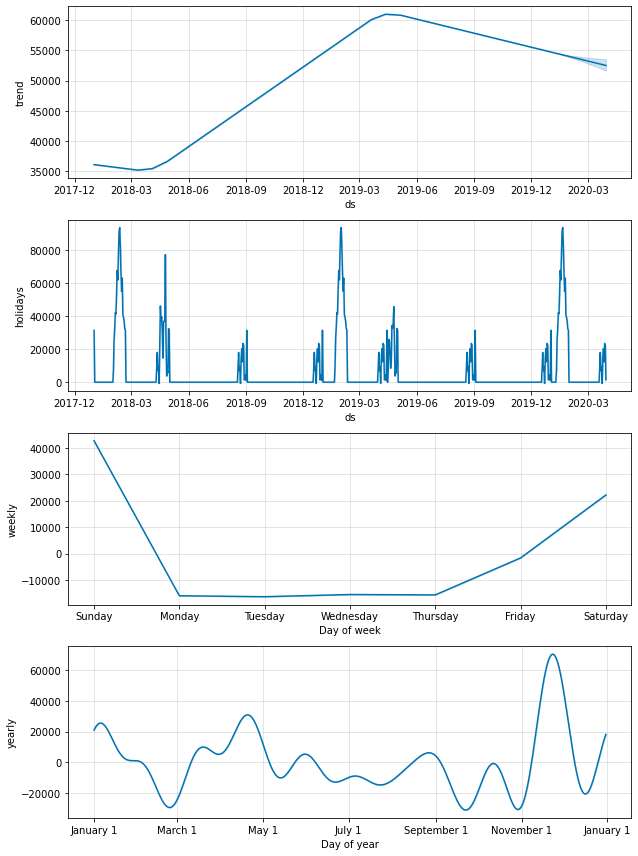

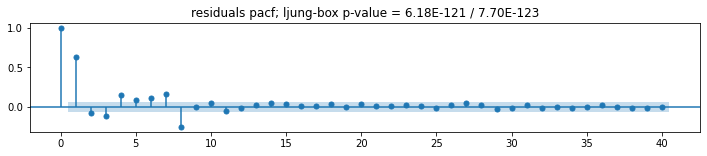

In [15]:
prophet_show(store='AEON TÂN PHÚ',df_train = final_df.copy(), cutoff_train="2020-01-01", cutoff_eval="2020-03-30",
             prophet_kwargs={'yearly_seasonality':True, 'weekly_seasonality':True,
                            'holidays':holidays_vn, 'uncertainty_samples':500},
            title='Prophet')